## Imports

In [1]:
# Activate project enviroment 
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\Herbert\Documents\GitHub\AMO_Project`


In [2]:
# die pakete die wir für dieses Notebook brauchen
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV

## Deterministic Market Clearing Formulation 

For our market clearing optimization problem we use the 24-bus system provided in Ilias. We do not consider line constraints. The model then consists of 12 conventional generators, 4 wind farms and 17 demands (see table below). For now, we consider the demands fixed, with a curtailment cost of 500. Thus, uncertainty only comes from wind energy of the 4 wind farms. In later work, it would make sense to increase the share of wind enery in the system by some percentage and compare results or to introduce flexible demands.

In order to analyze benefits of stochastic market clearing, we first need to formulate a deterministic market clearing model. To achieve realistic wind energy distributions for each wind farm and each hour we use the data set from https://sites.google.com/site/datasmopf/wind-scenarios. The dataset holds 100 scenarios of wind power output for 15 zones over 43 hours in hourly granularity (100 wind scenarios for each hour for each zone). The scenario values are normalized between 0 and 1. We will NOT be using the given scenarios directly to predict energy output, but rather fit Weibull distributions to the scenarios to be able to generate our own scenarios via Monte Carlo method.

While we don't need the distributions for the deterministic setting, we would like to use the mean of the distributions as the single value energy prediction in the determinstic setting to ensure comparability. Thus, in the first step, we fit the Weibull distributions to the scenarios (each hour of each wind farm has it's own independent distribution). To get actual wind energy values from the normalized scenarios, we consider the given energy forcast for each wind farm (see table) as the mean of the energy production level over all 43 hours. (i.e. if the mean value of the scenarios would be 0.5 and the energy forcast is 100, we get a factor of 200)

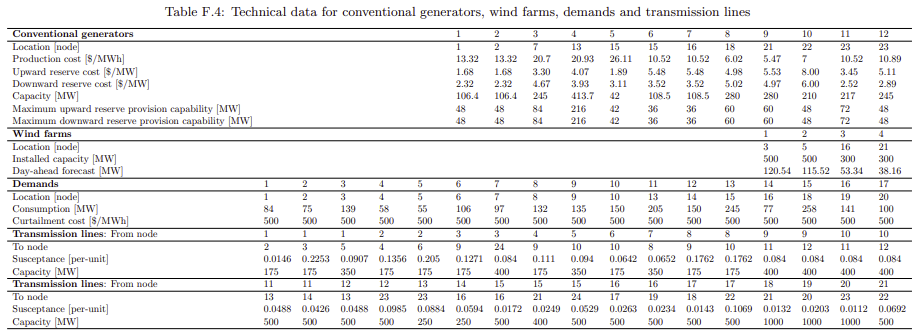

In [5]:
display("image/png", read("./resources/Model_table.PNG"))

In [ ]:
# read in wind data for the zones 1-4 corresponding to the wind farms 1-4
scenarios = [CSV.read("./resources/scen_zone1.csv", DataFrame),CSV.read("./resources/scen_zone2.csv", DataFrame),CSV.read("./resources/scen_zone3.csv", DataFrame),CSV.read("./resources/scen_zone4.csv", DataFrame)]

In [9]:
print(mean.(eachrow(scenarios[1])))

LoadError: AbstractDataFrame is not iterable. Use eachrow(df) to get a row iterator or eachcol(df) to get a column iterator

In [6]:
# scale the data to fit our model (set the predicted output to the mean of all scenarios)
function getMean(df)
    
energy_predictions = []
for i in scenarios

DataFrame[43×101 DataFrame
 Row │ Column1  V1         V2        V3         V4         V5          V6          V7         V8         V9         V10        V11        V12         V13        V14       V15       V16        V17        V18         V19        V20         V21         V22        V23       V24        V25        V26       V27        V28        V29         V30       V31        V32         V33        V34         V35       V36        V37        V38       V39       V40        V41       V42        V43       V44        V45        V46        V47       V48        V49        V50       V51        V52       V53       V54        V55        V56        V57         V58       V59         V60        V61        V62        V63        V64        V65       V66       V67        V68        V69        V70       V71        V72        V73       V74        V75       V76        V77       V78        V79       V80        V81        V82       V83       V84        V85        V86        V87         V88        V8